daligner で overlap 候補を絞ることにした。どの sync. read についてもほどほどのオーバーラップがあるような状態にするために、k-mer filtering などのパラメタを調整する。

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.INFO)

In [3]:
from dataclasses import dataclass
from typing import List, Tuple
from collections import Counter, defaultdict
import random
from copy import copy
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from logzero import logger
import consed
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.io import save_fasta
from BITS.seq.align import EdlibRunner
from BITS.seq.consed import ConsedRunner
from BITS.seq.utils import revcomp
from BITS.util.io import save_pickle, load_pickle
from BITS.util.proc import run_command, NoDaemonPool
from BITS.plot.plotly import make_line, make_hist, make_scatter, make_layout, show_plot
from vca.types import TRUnit

In [4]:
dir_fname = 'work/'
import os
os.chdir(dir_fname)

In [78]:
!(ls -l)

合計 682284
-rw-r--r-- 1 yoshihiko_s users       201  9月 22 19:13 2019 DMEL_CCS_CEN.db
-rw-r--r-- 1 yoshihiko_s users 109108500  9月 22 20:06 2019 DMEL_CCS_CEN.las
lrwxrwxrwx 1 yoshihiko_s users        41  9月 10 13:29 2019 DMEL_CSS.db -> ../../../data/dmel_pacbio_ccs/DMEL_CSS.db
-rw-r--r-- 1 yoshihiko_s users  15820708  9月  9 03:36 2019 TAN.DMEL_CSS.las
-rw-r--r-- 1 yoshihiko_s users  18880880  9月 15 05:59 2019 centromere_phreds.pkl
-rw-r--r-- 1 yoshihiko_s users  48465527  9月 19 06:44 2019 centromere_phreds_incl_low_cover_rate_all_sync.pkl
-rw-r--r-- 1 yoshihiko_s users   9535359  9月 17 20:22 2019 centromere_reads.fasta
-rw-r--r-- 1 yoshihiko_s users  10724811  9月 15 08:15 2019 centromere_reads.pkl
-rw-r--r-- 1 yoshihiko_s users  24235898  9月 19 04:54 2019 centromere_reads_incl_low_cover_rate.fasta
-rw-r--r-- 1 yoshihiko_s users  27410053  9月 19 04:51 2019 centromere_reads_incl_low_cover_rate.pkl
-rw-r--r-- 1 yoshihiko_s users  27990469  9月 19 18:48 2019 centromere_reads_incl_low_cover_r

In [5]:
sync_reads = load_pickle("../work/centromere_reads_incl_low_cover_rate_all_sync.pkl")

In [8]:
len(sync_reads)

1905

In [9]:
for read in sync_reads:
    for unit in read.units:
        assert unit.id in (0, 1)

In [7]:
sync_reads_by_id = {read.id: read for read in sync_reads}

## Reads covered by the master unit and the others

### All sync reads

In [10]:
cover_rates = [sum([unit.end - unit.start for unit in read.units]) / read.length for read in sync_reads]   # by master unit

In [11]:
show_plot([make_hist(cover_rates, bin_size=0.01)])

総量としては master 持ちの方が多いが、master と 10% 以上離れたユニットしか持たないリードも多数存在する (そしてそれらは綺麗にアセンブリできることがわかっている)

master 持ちが string graph にあまり現れないのは、repetitive k-mer が多すぎて daligner が overlap から弾いているから？

### Sync reads covered by master unit

In [12]:
sync_reads_master = [sync_reads[i] for i in range(len(sync_reads)) if cover_rates[i] != 0.]

In [13]:
save_pickle(sync_reads_master, "centromere_reads_incl_low_cover_rate_master.pkl")

## Check the k-mer distribution

In [16]:
def count_kmers(reads, k):
    kmers = Counter()
    for read in reads:
        for i in range(read.length - k + 1):
            kmers[read.seq[i:i + k]] += 1
            kmers[revcomp(read.seq[i:i + k])] += 1   # both forward and revcomp are counted; so the numer is duplicated
    return kmers

def plot_kmer_count_dist(kmers, max_count):
    # x-axis: k-mer count, y-axis: frequency of the k-mer counts
    pd.Series(list(kmers.values())).hist(bins=max_count, range=(1, max_count))
    plt.yscale('log')
    plt.show()

### All sync reads

In [14]:
kmers = count_kmers(sync_reads, k=24)

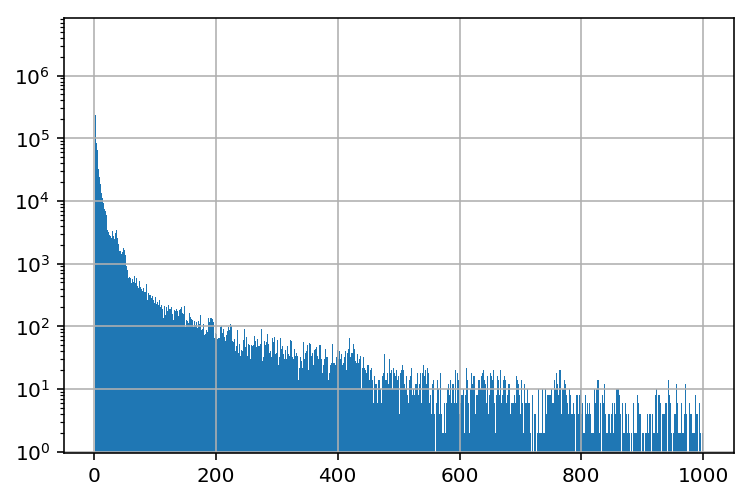

In [17]:
plot_kmer_count_dist(kmers, max_count=1000)

In [18]:
kmers = count_kmers(sync_reads, k=40)

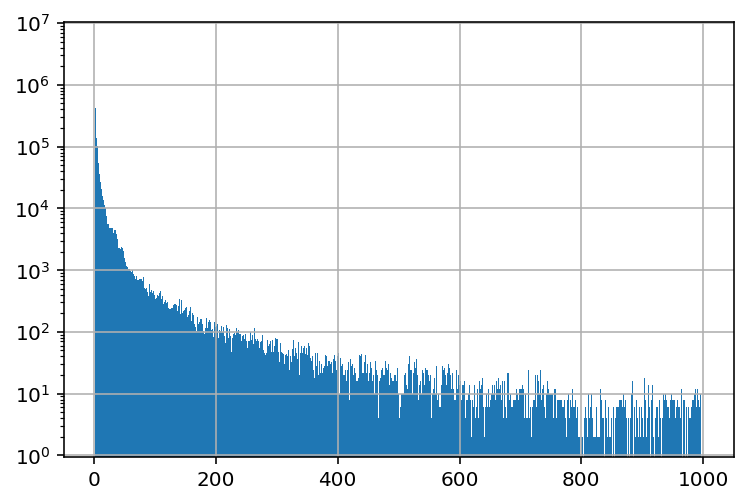

In [19]:
plot_kmer_count_dist(kmers, max_count=1000)

## Only sync reads covered by the master unit

In [152]:
kmers = count_kmers(sync_reads_master, k=24)

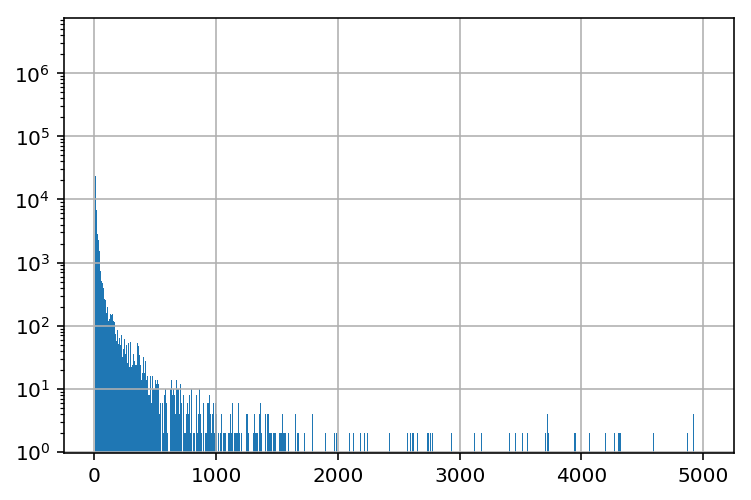

In [156]:
plot_kmer_count_dist(kmers, max_count=5000)

In [24]:
kmers = count_kmers(sync_reads_master, k=40)

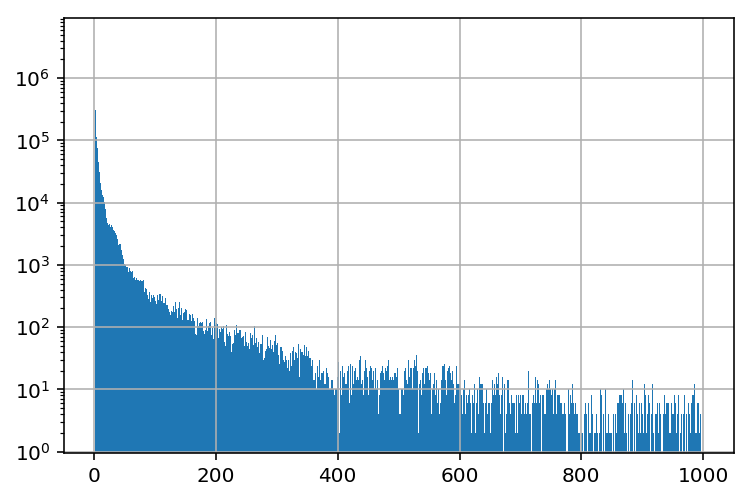

In [25]:
plot_kmer_count_dist(kmers, max_count=1000)

### Only sync reads NOT covered by the master unit

In [26]:
sync_reads_non_master = [sync_reads[i] for i in range(len(sync_reads)) if cover_rates[i] == 0.]

In [27]:
kmers = count_kmers(sync_reads_non_master, k=24)

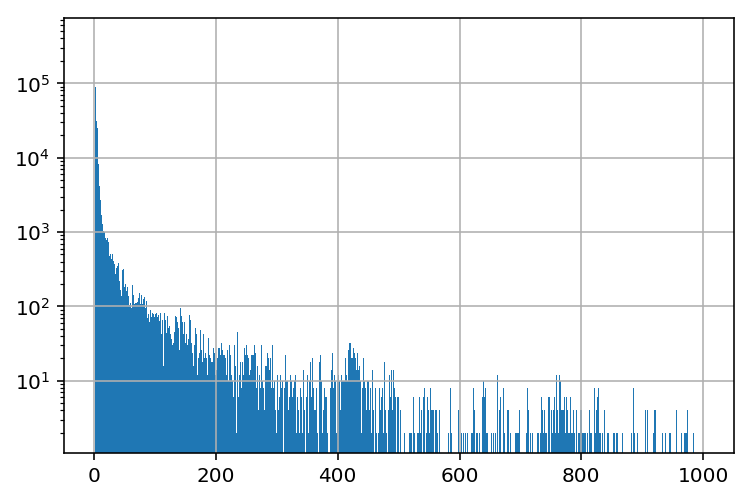

In [28]:
plot_kmer_count_dist(kmers, max_count=1000)

In [29]:
kmers = count_kmers(sync_reads_non_master, k=40)

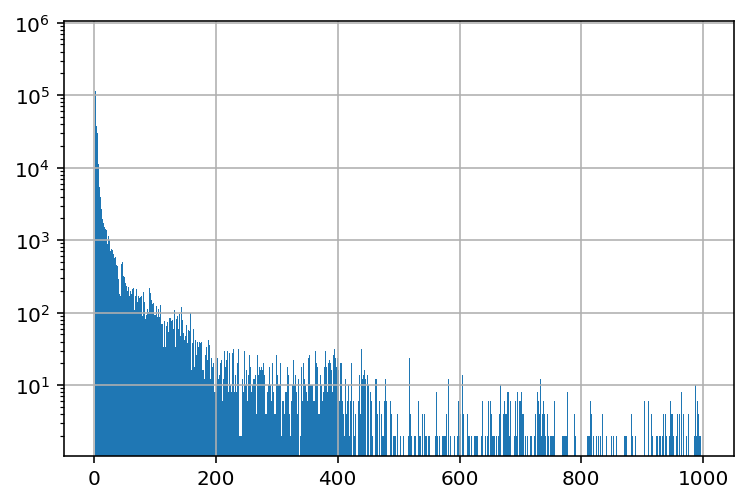

In [30]:
plot_kmer_count_dist(kmers, max_count=1000)

## Create DB file of sync. centromeric reads

とりあえず non-master を弾いてパラメタを調整してから、再度 non-master も含めて全部の overlap を出すか？もしくはもう完全に別々にアセンブリしてしまってもいい気もするが。。

In [313]:
# master sync reads だけを出力
save_fasta({read.name: read.seq for read in sync_reads_master},
           out_fname="centromere_reads_incl_low_cover_rate_master.fasta",
           sort=False,
           width=100)

In [314]:
!(rm DMEL_CCS_CEN.db .DMEL_CCS_CEN.*)

In [315]:
!(fasta2DB DMEL_CCS_CEN centromere_reads_incl_low_cover_rate_master.fasta)

In [316]:
!(DBsplit -s100 DMEL_CCS_CEN)

In [318]:
!(DBstats DMEL_CCS_CEN)


Statistics for all reads in the data set

          1,665 reads        out of           1,665  (100.0%)
     21,149,558 base pairs   out of      21,149,558  (100.0%)

         12,702 average read length
            767 standard deviation

  Base composition: 0.341(A) 0.161(C) 0.158(G) 0.340(T)

  Distribution of Read Lengths (Bin size = 1,000)

        Bin:      Count  % Reads  % Bases     Average
     15,000:          2      0.1      0.1       15081
     14,000:        101      6.2      6.9       14258
     13,000:        456     33.6     35.9       13583
     12,000:        782     80.5     82.1       12948
     11,000:        324    100.0    100.0       12702


## Run daligner

In [225]:
db_prefix = "DMEL_CCS_CEN"

In [320]:
!(rm {db_prefix}.las)
!(HPC.daligner -T16 -k24 -w5 -l3000 -h40 -e.99 -s500 -M400 -v {db_prefix} | bash -v)

rm: cannot remove `DMEL_CCS_CEN.las': そのようなファイルやディレクトリはありません
# Daligner jobs (1)
daligner -v -k24 -w5 -h40 -e0.99 -l3000 -s500 -M400 -T16 DMEL_CCS_CEN DMEL_CCS_CEN && mv DMEL_CCS_CEN.DMEL_CCS_CEN.las DMEL_CCS_CEN.las

Building index for DMEL_CCS_CEN

   Kmer count = 21,111,263
   Using 0.63Gb of space
   Index occupies 0.31Gb

Comparing DMEL_CCS_CEN to DMEL_CCS_CEN

   Capping mutual k-mer matches over 10000 (effectively -t100)
   Hit count = 77,638,615
   Highwater of 2.63Gb space

     77,638,615 24-mers (1.735702e-07 of matrix)
      2,397,501 seed hits (5.359894e-09 of matrix)
        144,510 confirmed hits (3.230690e-10 of matrix)

Building index for c(DMEL_CCS_CEN)

   Kmer count = 21,111,263
   Using 0.63Gb of space
   Index occupies 0.31Gb

Comparing DMEL_CCS_CEN to c(DMEL_CCS_CEN)

   Capping mutual k-mer matches over 10000 (effectively -t100)
   Hit count = 77,453,916
   Highwater of 2.62Gb space

     77,453,916 24-mers (1.731573e-07 of matrix)
      2,398,377 seed hits (5.3

どうやら daligner の内部で自動で`-t100`に制限されているようなので、.db の方をこの数に合わせて分割して all-vs-all する。

## Functions

In [38]:
def las_to_ovlps(db_prefix):
    ovlps = []
    for line in run_command(f"LAdump -ocdl {db_prefix}.db {db_prefix}.las").split('\n'):
        if line.startswith('P'):
            _, a_read, b_read, strand, _ = line.strip().split(' ')
            a_read, b_read = map(int, (a_read, b_read))
        elif line.startswith('L'):
            _, a_len, b_len = line.strip().split(' ')
            a_len, b_len = map(int, (a_len, b_len))
        elif line.startswith('C'):
            _, a_start, a_end, b_start, b_end = line.strip().split(' ')
            a_start, a_end, b_start, b_end = map(int, (a_start, a_end, b_start, b_end))
        elif line.startswith('D'):
            _, n_diff = line.strip().split(' ')
            n_diff = int(n_diff)
            p_diff = round(n_diff / ((a_end - a_start + b_end - b_start) / 2) * 100, 2)   # in percentage
            ovlps.append((a_read, b_read, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff))
    return ovlps

In [39]:
def construct_string_graph(overlaps):
    nodes, edges = set(), set()
    for overlap in overlaps:
        f_id, g_id, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff = overlap
        
        if strand == 'c':
            # a_read[a_start:a_end] ~~ strand(b_read[b_start:b_end]) となるようにする
            # b の座標は常に b_read を forward に見た時のもの。配列の切り出しが先。revcomp は後。
            b_start, b_end = b_len - b_end, b_len - b_start
            
        if a_start > 0:
            if strand == 'n':
                if b_end == b_len:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     --------->
                          g.B        g.E
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         ------------->
                                g.B           g.E
                    """
                    overlap_type = "suffix-prefix"
            else:
                if b_start == 0:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     <---------
                          g.E        g.B
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         <-------------
                                g.E           g.B
                    """
                    overlap_type = "suffix-suffix"
        else:
            if a_end == a_len:
                overlap_type = "contained"
            else:
                if strand == 'n':
                    """
                                f.B         f.E
                      f          ----------->
                      g    ----------->
                         g.B          g.E
                    """
                    if b_start == 0:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-suffix"
                else:
                    """
                                f.B         f.E
                      f          ----------->
                      g    <-----------
                         g.E           g.B
                    """
                    if b_end == b_len:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-prefix"

        if overlap_type in ["contains", "contained"]:
            continue
        elif overlap_type == "suffix-prefix":
            nodes.update(["%s:B" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:E" % g_id])
            edges.update([("%s:B" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:E" % g_id, b_len - b_end, p_diff)])
        elif overlap_type == "suffix-suffix":
            nodes.update(["%s:E" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:B" % g_id])
            edges.update([("%s:E" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:B" % g_id, b_start, p_diff)])
        elif overlap_type == "prefix-suffix":
            nodes.update(["%s:B" % f_id,
                          "%s:B" % g_id,
                          "%s:E" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:B" % g_id, b_start, p_diff),
                          ("%s:E" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])
        else:   # prefix-prefix
            nodes.update(["%s:B" % f_id,
                          "%s:E" % g_id,
                          "%s:B" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:E" % g_id, b_len - b_end, p_diff),
                          ("%s:B" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])

    return ig.Graph.DictList(edges=(dict(source=s, target=t, length=l, diff=p) for s, t, l, p in edges),
                             vertices=None,
                             directed=True)

def transitive_reduction(sg):
    v_mark = ["vacant" for v in sg.vs]
    e_reduce = {e.tuple: False for e in sg.es}
    FUZZ = 10   # in bp; this length is in general shorter than unit length, thus we accept no unit shifts

    for v in sg.vs:
        if v.outdegree() == 0:
            continue

        oes = sorted(sg.es.select(_source=v.index), key=lambda x: x["length"])
        longest = oes[-1]["length"] + FUZZ
        for oe in oes:
            v_mark[oe.target] = "inplay"

        for oe in oes:
            if v_mark[oe.target] == "inplay":
                ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
                for ooe in ooes:
                    if oe["length"] + ooe["length"] <= longest and v_mark[ooe.target] == "inplay":
                        v_mark[ooe.target] = "eliminated"

        for oe in oes:
            ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
            if len(ooes) > 1:
                shortest = ooes[0].target
                if v_mark[shortest] == "inplay":
                    v_mark[shortest] == "eliminated"
            for ooe in ooes:
                if ooe["length"] < FUZZ and v_mark[ooe.target] == "inplay":
                    v_mark[ooe.target] = "eliminated"

        for oe in oes:
            if v_mark[oe.target] == "eliminated":
                e_reduce[oe.tuple] = True   # TODO: confirm revcomp edges will be also removed in the same way
            v_mark[oe.target] = "vacant"

    # Re-construct a graph
    return ig.Graph.DictList(edges=(dict(source=e["source"],
                                         target=e["target"],
                                         length=e["length"],
                                         diff=e["diff"])
                                    for e in sg.es
                                    if not e_reduce[e.tuple]),
                             vertices=None,
                             directed=True)

In [74]:
def draw_graph(sg):
    E = [e.tuple for e in sg.es]
    N = sg.vcount()
    pos = sg.layout('kk')

    edge_trace = go.Scatter(x=[i for l in [(pos[s][0], pos[t][0], None) for s, t in E] for i in l],
                            y=[i for l in [(pos[s][1], pos[t][1], None) for s, t in E] for i in l],
                            line=dict(width=0.5, color='black'),
                            mode='lines')

    shapes = [make_line(pos[s][0] + (pos[t][0] - pos[s][0]) * 0.7,
                        pos[s][1] + (pos[t][1] - pos[s][1]) * 0.7,
                        pos[t][0],
                        pos[t][1],
                        "black",
                        4,
                        "below")
              for s, t in E]
    
    reads = [sync_reads_by_id[int(sg.vs[node]["name"].split(':')[0])] for node in range(N)]
    cover_rates = [sum([unit.end - unit.start for unit in read.units]) / read.length for read in reads]   # by 359-bp units

    node_trace = go.Scatter(x=[pos[node][0] for node in range(N)],
                            y=[pos[node][1] for node in range(N)],
                            text=[f"{sg.vs[node]['name']}<br>{round(cover_rates[node] * 100, 1)}% covered" for node in range(N)],
                            mode='markers',
                            marker=dict(
                                color=[cr for cr in cover_rates],
                                showscale=False,
                                colorscale='YlGnBu',
                                reversescale=False,
                                size=10,
                                line=dict(width=2)))

    layout = go.Layout(width=1000, height=1000,
                       xaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       yaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       shapes=shapes,
                       hovermode='closest',
                       margin=go.layout.Margin(l=0, r=0, b=0, t=0),
                       showlegend=False)
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    py.iplot(fig)
    return pos

## MaxDiff=1%MinLen=4000

In [114]:
# before transitive reduction
sg = construct_string_graph(ovlps)
cc = [(g, g.vcount()) for g in sg.clusters(mode="weak").subgraphs() if g.vcount() >= 10]
for g, s in cc:
    draw_graph(g)

In [112]:
# after transitive reduction
sg = transitive_reduction(construct_string_graph(ovlps))
cc = [(g, g.vcount()) for g in sg.clusters(mode="weak").subgraphs() if g.vcount() >= 10]
for g, s in cc:
    draw_graph(g)

ユニークな k-mer を持つ non-master reads は綺麗にアセンブリできている。そうでないものについてはそもそも overlap のほとんどが filter されてしまっている。なので、リードを細かく分割して all-vs-all overlap を取ることにする。

## All-vs-all daligner

すべてのリードのペアについて overlap を計算することにする

In [310]:
sorted(filter(lambda x: x[-1] < 1., all_ovlps))

[(1, 5, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (8, 22, 'c', 0, 12694, 13428, 306, 13014, 13014, 31, 0.24),
 (30, 22, 'c', 8543, 12807, 12807, 0, 4264, 11656, 10, 0.23)]

In [312]:
sorted(filter(lambda x: x[-1] < 1., all_ovlps))

[(1, 45, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (30, 32, 'c', 8543, 12807, 12807, 0, 4264, 11656, 10, 0.23)]

-> 1 block 30 reads だと見つかった overlap が 1 block 50 reads だと見つからなくなっている。

多分もっと効率的な seed の設計がある。長い k-mer か、global k-varvec か。

前者は、40-mer でも >100 counts のものが多数あることが分かっている。さらに、現在の daligner では 32-mer 以上を使えない。

In [247]:
def reads_to_fasta(reads, out_fname):
    save_fasta({read.name: read.seq for read in reads}, out_fname=out_fname, sort=False, width=100)

In [421]:
def aa_las_to_ovlps(pid):
    ovlps = []
    for line in run_command(f"LAdump -ocdl A_READ_{pid}.db A_READ_{pid}.A_READ_{pid}.las").split('\n'):
        if line.startswith('P'):
            _, a_read, b_read, strand, _ = line.strip().split(' ')
            a_read, b_read = map(int, (a_read, b_read))
        elif line.startswith('L'):
            _, a_len, b_len = line.strip().split(' ')
            a_len, b_len = map(int, (a_len, b_len))
        elif line.startswith('C'):
            _, a_start, a_end, b_start, b_end = line.strip().split(' ')
            a_start, a_end, b_start, b_end = map(int, (a_start, a_end, b_start, b_end))
        elif line.startswith('D'):
            _, n_diff = line.strip().split(' ')
            n_diff = int(n_diff)
            p_diff = round(n_diff / ((a_end - a_start + b_end - b_start) / 2) * 100, 2)   # in percentage
            if a_read < b_read:   # remove duplicate overlaps
                ovlps.append((a_read, b_read, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff))
    return ovlps

def ab_las_to_ovlps(pid):
    ovlps = []
    for line in run_command(f"LAdump -ocdl A_READ_{pid}.db B_READ_{pid}.db A_READ_{pid}.B_READ_{pid}.las").split('\n'):
        if line.startswith('P'):
            _, a_read, b_read, strand, _ = line.strip().split(' ')
            a_read, b_read = map(int, (a_read, b_read))
        elif line.startswith('L'):
            _, a_len, b_len = line.strip().split(' ')
            a_len, b_len = map(int, (a_len, b_len))
        elif line.startswith('C'):
            _, a_start, a_end, b_start, b_end = line.strip().split(' ')
            a_start, a_end, b_start, b_end = map(int, (a_start, a_end, b_start, b_end))
        elif line.startswith('D'):
            _, n_diff = line.strip().split(' ')
            n_diff = int(n_diff)
            p_diff = round(n_diff / ((a_end - a_start + b_end - b_start) / 2) * 100, 2)   # in percentage
            ovlps.append((a_read, b_read, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff))
    return ovlps

In [440]:
def overlap_block(i):
    """Run daligner between block i and block (i+1)-<n_blocks>."""
    pid = os.getpid()
    block_ovlps = []
    
    logger.info(f"block {i + 1}")
    a_reads = sync_reads_master[i * n_reads_per_block:(i + 1) * n_reads_per_block]
    run_command(f"rm -f a_reads_{pid}.fasta A_READ_{pid}.db .A_READ_{pid}.*")
    reads_to_fasta(a_reads, f"a_reads_{pid}.fasta")
    run_command(f"fasta2DB A_READ_{pid} a_reads_{pid}.fasta; DBsplit -s100 A_READ_{pid}")
    logger.info("created a reads")
    
    # compute overlaps in the A reads (= block i vs block i)
    run_command(f"rm -f A_READ_{pid}.A_READ_{pid}.las")
    run_command(f"daligner -T16 -k25 -w5 -l3000 -h60 -e.99 -s1000 A_READ_{pid} A_READ_{pid}")
    ovlps = aa_las_to_ovlps(pid)

    # adjust read IDs
    ovlps = [(ovlp[0] + i * n_reads_per_block, ovlp[1] + i * n_reads_per_block, *ovlp[2:]) for ovlp in ovlps]
    block_ovlps += ovlps
    
    for j in range(i + 1, n_blocks):
        b_reads = sync_reads_master[j * n_reads_per_block:(j + 1) * n_reads_per_block]
        run_command(f"rm -f b_reads_{pid}.fasta B_READ_{pid}.db .B_READ_{pid}.*")
        reads_to_fasta(b_reads, f"b_reads_{pid}.fasta")
        run_command(f"fasta2DB B_READ_{pid} b_reads_{pid}.fasta; DBsplit -s100 B_READ_{pid}")
        logger.info("created b reads")
        
        run_command(f"rm -f A_READ_{pid}.B_READ_{pid}.las B_READ_{pid}.A_READ_{pid}.las")
        run_command(f"daligner -T16 -k25 -w5 -l3000 -h60 -e.99 -s1000 A_READ_{pid} B_READ_{pid}")
        ovlps = ab_las_to_ovlps(pid)
        
        # adjust read IDs
        ovlps = [(ovlp[0] + i * n_reads_per_block, ovlp[1] + j * n_reads_per_block, *ovlp[2:]) for ovlp in ovlps]
        block_ovlps += ovlps
        
    run_command(f"rm -f a_reads_{pid}.fasta A_READ_{pid}.db .A_READ_{pid}.*")
    run_command(f"rm -f b_reads_{pid}.fasta B_READ_{pid}.db .B_READ_{pid}.*")
    run_command(f"rm -f A_READ_{pid}.A_READ_{pid}.las")
    run_command(f"rm -f A_READ_{pid}.B_READ_{pid}.las B_READ_{pid}.A_READ_{pid}.las")
    return block_ovlps

## n_reads_per_block=10

In [479]:
n_reads_per_block = 10   # only k-mers with relative frequency (in 2 blocks) less than 100/(60 * <n_reads_per_block>)
                         # will be used for seed in daligner, where n is the number of reads in a single block
n_blocks = -(-len(sync_reads_master) // n_reads_per_block)
logger.info(f"#blocks = {n_blocks}")

[I 190923 00:43:36 <ipython-input-479-3454493bc128>:4] #blocks = 167


In [480]:
all_ovlps = []
with NoDaemonPool(20) as pool:
    for ret in pool.map(overlap_block, list(range(n_blocks))):
        all_ovlps += ret

[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 1
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 4
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 13
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 7
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 10
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 16
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 19
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 25
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 37
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 31
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 28
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 22
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 34
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 40
[I 190923 00:43:42 <ipython-input-440-cee9d3e81bbe>:6] block 52
[I 190923 00:43:42 <ipython-input-440-cee9d

[I 190923 00:43:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:43:53 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:07 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:19 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:44:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:32 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:45 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:44:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:44:59 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:45:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:12 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:45:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:25 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:39 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:45:52 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:46:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:06 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:19 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:33 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:46:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:46 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:46:59 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:47:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:13 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:47:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:26 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:47:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:39 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:47:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:47:52 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:05 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:48:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:17 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:30 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:48:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:43 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:48:56 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:08 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:21 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:49:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:34 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:47 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:49:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:49:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:00 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:50:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:13 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:26 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:50:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:39 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:50:52 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:51:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:06 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:51:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:19 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:32 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:51:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:45 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:51:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:51:58 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:11 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:24 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:37 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:6] block 51
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:52:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:04 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:53:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:16 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:53:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:29 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:53:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:43 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:53:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:6] block 36
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:53:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 00:54:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:09 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:6] block 27
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 00:54:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:35 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:54:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:47 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:54:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:00 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:55:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:13 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:55:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:26 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:39 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:55:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:55:51 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:6] block 61
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:16 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:29 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:42 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:56:55 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:05 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:57:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:6] block 70
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:6] block 73
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 19092

[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:30 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:43 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:57:56 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:58:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:09 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:23 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:35 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:58:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:58:48 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:01 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:01 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:01 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:01 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:01 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:14 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:59:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:26 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:28 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:39 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:40 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 00:59:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:52 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 00:59:53 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:05 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:07 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:19 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:00:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:32 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:00:43 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:45 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:00:58 <ipython-input-440-cee9d3e81bbe>:6] block 68


[I 190923 01:01:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:11 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:6] block 103
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:01:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:38 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:38 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:01:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:49 <ipython-input-440-cee9d3e81bbe>:6] block 109
[I 190923 01:01:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:01:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:02:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:05 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:18 <ipython-input-440-cee9d3e81bbe>:6] block 112
[I 190923 01:02:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:18 <ipython-input-440-cee9d3e81bbe>:11] created a reads

[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:6] block 115
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:30 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:44 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:02:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:6] block 98
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:02:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:09 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:10 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:03:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:22 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:23 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:03:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:37 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:51 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:03:51 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:04:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:04 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:04 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:04:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:17 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:17 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:04:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:29 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:42 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:55 <ipython-input-440-cee9d3e81bbe>:6] block 119
[I 190923 01:04:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:04:55 <ipython-input-440-cee9d3e81bbe>:11] created a reads

[I 190923 01:05:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:08 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:21 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:6] block 93
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:34 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:05:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads


[I 190923 01:05:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:47 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:58 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:05:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:00 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:06:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:11 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:12 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:13 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:06:23 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:24 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:25 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:25 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:06:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:37 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:06:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:49 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:06:50 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:07:01 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:02 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:03 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:15 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:16 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:16 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:07:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:27 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:28 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:29 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:40 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:41 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:42 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:42 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:07:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:53 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:07:54 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:06 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:07 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:18 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:19 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:6] block 154
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:6] block 157
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:31 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190

[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:43 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:6] block 167
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:44 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:08:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:08:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:55 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:6] block 165
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:56 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:08:57 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:09:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:07 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:08 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:09 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:19 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:20 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:21 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:09:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:32 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:6] block 150
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:09:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:09:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:45 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:46 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:47 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:47 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:6] block 132
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:11] created a reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:09:59 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:00 <ipython-input-440-cee9d3e81bbe>:27] created b reads

[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:13 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:14 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:15 <ipython-input-440-cee9d3e81bbe>:27] created 

[I 190923 01:10:33 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:34 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:35 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:36 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:37 <ipython-input-440-cee9d3e81bbe>:27] created b reads
[I 190923 01:10:38 <ipython-input-440-cee9d3e81bbe>:27] created 

In [481]:
sorted(all_ovlps)[:100]

[(1, 95, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (1, 704, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (1, 896, 'c', 10353, 13814, 13814, 0, 3466, 12602, 132, 3.81),
 (1, 1193, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (1, 1448, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (3, 327, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87),
 (4, 233, 'n', 0, 4016, 13059, 8120, 12133, 12133, 6, 0.15),
 (4, 436, 'c', 8981, 13059, 13059, 0, 4079, 13405, 135, 3.31),
 (4, 789, 'c', 9562, 13059, 13059, 0, 3491, 14118, 158, 4.52),
 (4, 832, 'n', 5076, 13059, 13059, 0, 7943, 12610, 96, 1.21),
 (5, 290, 'c', 0, 3494, 12117, 9916, 13414, 13414, 27, 0.77),
 (5, 327, 'n', 0, 3746, 12117, 10218, 13950, 13950, 80, 2.14),
 (5, 1639, 'c', 8331, 12117, 12117, 0, 3788, 12858, 11, 0.29),
 (6, 781, 'c', 0, 11453, 11453, 1177, 12692, 13471, 148, 1.29),
 (7, 40, 'n', 0, 3303, 12867, 8882, 12169, 12169, 164, 4.98),
 (7, 42, 'c', 0, 3125, 12867, 10662, 13769, 13769, 185, 5.94)

In [482]:
sorted(filter(lambda x: x[-1] < 1., all_ovlps))[:100]

[(1, 95, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (1, 704, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (1, 1193, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (1, 1448, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (4, 233, 'n', 0, 4016, 13059, 8120, 12133, 12133, 6, 0.15),
 (5, 290, 'c', 0, 3494, 12117, 9916, 13414, 13414, 27, 0.77),
 (5, 1639, 'c', 8331, 12117, 12117, 0, 3788, 12858, 11, 0.29),
 (7, 529, 'n', 0, 7200, 12867, 5397, 12593, 12593, 18, 0.25),
 (7, 1001, 'c', 1430, 12867, 12867, 0, 11433, 13101, 57, 0.5),
 (8, 355, 'c', 11134, 14494, 14494, 0, 3349, 14370, 16, 0.48),
 (8, 474, 'c', 0, 8080, 14494, 4263, 12335, 12335, 12, 0.15),
 (8, 717, 'n', 9058, 14494, 14494, 0, 5417, 14534, 30, 0.55),
 (8, 950, 'c', 0, 4781, 14494, 8532, 13310, 13310, 5, 0.1),
 (8, 1115, 'c', 0, 8778, 14494, 4545, 13299, 13299, 40, 0.46),
 (10, 481, 'c', 0, 4629, 12604, 6776, 11411, 11411, 22, 0.47),
 (11, 898, 'c', 2843, 14235, 14235, 0, 11400, 12256, 39, 0.34),
 (

In [483]:
cur_id_to_ori_id = {i + 1: sync_reads_master[i].id for i in range(len(sync_reads_master))}

In [484]:
orig_id_all_ovlps = [(cur_id_to_ori_id[ovlp[0]], cur_id_to_ori_id[ovlp[1]], *ovlp[2:]) for ovlp in all_ovlps]

In [485]:
sorted(filter(lambda x: x[-1] < 3., orig_id_all_ovlps))[:100]

[(73, 16873, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (73, 198167, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (73, 317383, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (73, 381787, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (236, 87619, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87),
 (300, 54493, 'n', 0, 4016, 13059, 8120, 12133, 12133, 6, 0.15),
 (300, 231958, 'n', 5076, 13059, 13059, 0, 7943, 12610, 96, 1.21),
 (369, 75008, 'c', 0, 3494, 12117, 9916, 13414, 13414, 27, 0.77),
 (369, 87619, 'n', 0, 3746, 12117, 10218, 13950, 13950, 80, 2.14),
 (369, 436104, 'c', 8331, 12117, 12117, 0, 3788, 12858, 11, 0.29),
 (395, 219903, 'c', 0, 11453, 11453, 1177, 12692, 13471, 148, 1.29),
 (546, 147506, 'n', 0, 7200, 12867, 5397, 12593, 12593, 18, 0.25),
 (546, 273709, 'c', 1430, 12867, 12867, 0, 11433, 13101, 57, 0.5),
 (559, 95028, 'c', 11134, 14494, 14494, 0, 3349, 14370, 16, 0.48),
 (559, 132531, 'c', 0, 3067, 14494, 9264, 12335, 12335, 67, 2.18),
 

In [486]:
save_pickle(sorted(orig_id_all_ovlps), "all_overlaps.pkl")

In [487]:
all_ovlps = load_pickle("all_overlaps.pkl")   # IDs are original and sorted; overlaps are not duplicated

In [488]:
len(all_ovlps)

100326

In [496]:
all_ovlps

[(73, 16873, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (73, 198167, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (73, 248245, 'c', 10353, 13814, 13814, 0, 3466, 12602, 132, 3.81),
 (73, 317383, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (73, 381787, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (236, 87619, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87),
 (300, 54493, 'n', 0, 4016, 13059, 8120, 12133, 12133, 6, 0.15),
 (300, 118021, 'c', 8981, 13059, 13059, 0, 4079, 13405, 135, 3.31),
 (300, 221733, 'c', 9562, 13059, 13059, 0, 3491, 14118, 158, 4.52),
 (300, 231958, 'n', 5076, 13059, 13059, 0, 7943, 12610, 96, 1.21),
 (369, 75008, 'c', 0, 3494, 12117, 9916, 13414, 13414, 27, 0.77),
 (369, 87619, 'n', 0, 3746, 12117, 10218, 13950, 13950, 80, 2.14),
 (369, 436104, 'c', 8331, 12117, 12117, 0, 3788, 12858, 11, 0.29),
 (395, 219903, 'c', 0, 11453, 11453, 1177, 12692, 13471, 148, 1.29),
 (546, 6428, 'n', 0, 3303, 12867, 8882, 12169, 12169, 164, 4.98),

In [553]:
# Filter overlaps by %diff and overlap length
max_diff = 1.
min_len = 3000
ovlps = list(filter(lambda ovlp: ovlp[-1] < max_diff and ovlp[4] - ovlp[3] >= min_len, all_ovlps))

In [554]:
len(ovlps)

1446

In [503]:
ovlps

[(73, 16873, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (73, 198167, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (73, 317383, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (73, 381787, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (236, 87619, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87),
 (300, 54493, 'n', 0, 4016, 13059, 8120, 12133, 12133, 6, 0.15),
 (300, 231958, 'n', 5076, 13059, 13059, 0, 7943, 12610, 96, 1.21),
 (369, 75008, 'c', 0, 3494, 12117, 9916, 13414, 13414, 27, 0.77),
 (369, 436104, 'c', 8331, 12117, 12117, 0, 3788, 12858, 11, 0.29),
 (395, 219903, 'c', 0, 11453, 11453, 1177, 12692, 13471, 148, 1.29),
 (546, 147506, 'n', 0, 7200, 12867, 5397, 12593, 12593, 18, 0.25),
 (546, 273709, 'c', 1430, 12867, 12867, 0, 11433, 13101, 57, 0.5),
 (559, 95028, 'c', 11134, 14494, 14494, 0, 3349, 14370, 16, 0.48),
 (559, 132531, 'c', 0, 7010, 14494, 5334, 12335, 12335, 126, 1.8),
 (559, 132531, 'c', 0, 8080, 14494, 4263, 12335, 12335, 12, 0.15),
 

In [555]:
# 各リードの overlap の数
n_ovlps = Counter()   # {read_id: ovlp_count}
for ovlp in ovlps:
    n_ovlps[ovlp[0]] += 1
    n_ovlps[ovlp[1]] += 1

In [556]:
n_ovlps_for_each_read = [n_ovlps[read.id] for read in sync_reads_master]

In [557]:
show_plot([make_hist(n_ovlps_for_each_read, bin_size=1)])

多くのリードで 0 overlap、これはよくない

non-master read では overlap が取れているので、問題は max_diff や min_len ではなく k-mer seed hit

In [507]:
sg = transitive_reduction(construct_string_graph(ovlps))

In [508]:
cc = [(g, g.vcount()) for g in sg.clusters(mode="weak").subgraphs() if g.vcount() >= 10]

In [509]:
cc

[(<igraph.Graph at 0x2b501dd794f8>, 13),
 (<igraph.Graph at 0x2b501dd78408>, 13),
 (<igraph.Graph at 0x2b5023359318>, 314),
 (<igraph.Graph at 0x2b5023359d68>, 98),
 (<igraph.Graph at 0x2b501dd7d7c8>, 23),
 (<igraph.Graph at 0x2b4fd00f26d8>, 27),
 (<igraph.Graph at 0x2b4fd00f2a98>, 98),
 (<igraph.Graph at 0x2b4fd00f2e58>, 13),
 (<igraph.Graph at 0x2b4fd00ed228>, 13),
 (<igraph.Graph at 0x2b4feadedc78>, 17),
 (<igraph.Graph at 0x2b4feade2048>, 10),
 (<igraph.Graph at 0x2b4feade2b88>, 16),
 (<igraph.Graph at 0x2b4feade2228>, 17),
 (<igraph.Graph at 0x2b4feade2318>, 10),
 (<igraph.Graph at 0x2b4feade2408>, 13),
 (<igraph.Graph at 0x2b4feadca228>, 13),
 (<igraph.Graph at 0x2b4feadca4f8>, 23),
 (<igraph.Graph at 0x2b4feadcaa98>, 17),
 (<igraph.Graph at 0x2b4feadc6d68>, 11),
 (<igraph.Graph at 0x2b4feadbcb88>, 13),
 (<igraph.Graph at 0x2b4feadbcc78>, 34),
 (<igraph.Graph at 0x2b4fead32318>, 13),
 (<igraph.Graph at 0x2b4fead324f8>, 16),
 (<igraph.Graph at 0x2b4fead32b88>, 15),
 (<igraph.Graph

In [510]:
for g, s in cc:
    draw_graph(g)

## Look at some reads not having any overlaps

In [524]:
db_prefix = "DMEL_CSS"
db_fname = f"{db_prefix}.db"
las_fname = f"TAN.{db_prefix}.las"
from vca import ReadViewer
v = ReadViewer(db_fname, las_fname)

In [537]:
list(filter(lambda x: n_ovlps[x[0]] == 0, [(read.id, round(cover_rates_master[i], 3)) for i, read in enumerate(sync_reads_master)]))

[(123, 0.363),
 (738, 0.928),
 (4062, 0.946),
 (4443, 0.371),
 (5299, 0.515),
 (5936, 0.445),
 (6290, 0.917),
 (7333, 0.485),
 (7556, 0.969),
 (7723, 0.889),
 (7726, 0.348),
 (9352, 0.863),
 (12240, 0.919),
 (18133, 0.82),
 (21611, 0.96),
 (21991, 0.417),
 (22844, 0.89),
 (23271, 0.842),
 (23402, 0.643),
 (23489, 0.991),
 (25482, 0.897),
 (25515, 0.981),
 (25794, 0.515),
 (27092, 0.9),
 (27705, 0.929),
 (34738, 0.97),
 (35217, 0.893),
 (36742, 0.944),
 (38512, 0.343),
 (41676, 0.934),
 (44025, 0.365),
 (45979, 0.645),
 (48764, 0.482),
 (49512, 0.441),
 (51006, 0.474),
 (51150, 0.957),
 (51570, 0.448),
 (57248, 0.946),
 (63730, 0.587),
 (69357, 0.743),
 (69456, 0.812),
 (69925, 0.478),
 (72925, 0.448),
 (73637, 0.518),
 (73755, 0.398),
 (74332, 0.952),
 (80486, 0.615),
 (81275, 0.387),
 (86550, 0.861),
 (90102, 0.415),
 (90816, 0.92),
 (90941, 0.785),
 (92588, 0.457),
 (94197, 0.578),
 (96104, 0.469),
 (97595, 0.475),
 (98332, 0.303),
 (102171, 0.645),
 (102745, 0.398),
 (102830, 0.976)

In [549]:
read_id = 51150
v.show(read_id)

In [550]:
read = sync_reads_by_id[read_id]
[EdlibRunner("global", revcomp=True).align(read.repr_units[0], read.seq[unit.start:unit.end]).cigar.flatten().string
 for unit in read.units]

['=X===X=XX===========================================X========================================================X=====X===============================X===============================X======X======X==================================D=============================X============X==============================X======================I======X=========X============X====',
 '=X=====================================================X===============X======================================================X=======X================X=============X===X=====XX===================================================D=========================X===X===========================================X======================I======X=========X============X====',
 '=X===X=XX===========================================X========================================================X=====X==============================X======================X==========I===============================================D===X======================X=X==========

-> variant は存在する！つまり、overlap の候補さえ絞れたら勝ち

## n_reads_per_block=1

これでも overlap = 0 のリードが大量にあるようなら daligner-based は諦めて variant vector もしくは別の aligner に変更する。

In [ ]:
all_ovlps = load_pickle("parallel_ava/all_ovlps.pkl")

## Extract overlaps only of single read

In [75]:
# Extract overlaps of a read
read_id = 440479
read_ovlps = list(filter(lambda x: x[0] == read_id or x[1] == read_id, ovlps))
for o in read_ovlps:
    print(o)
tuple(set([xx for x in read_ovlps for xx in x[:2]]))

(105948, 440479, 'n', 5475, 13245, 13245, 0, 7774, 14294, 121, 1.56)
(205738, 440479, 'n', 7615, 12127, 12127, 0, 4516, 14294, 20, 0.44)
(294132, 440479, 'c', 0, 3173, 13648, 11121, 14294, 14294, 0, 0.0)
(354265, 440479, 'c', 0, 5832, 12217, 8456, 14294, 14294, 55, 0.94)
(426341, 440479, 'c', 0, 6374, 13313, 7922, 14294, 14294, 3, 0.05)
(440479, 105948, 'n', 0, 7774, 14294, 5475, 13245, 13245, 121, 1.56)
(440479, 205738, 'n', 0, 4516, 14294, 7615, 12127, 12127, 20, 0.44)
(440479, 294132, 'c', 0, 3173, 14294, 10475, 13648, 13648, 0, 0.0)
(440479, 354265, 'c', 0, 5838, 14294, 6385, 12217, 12217, 55, 0.94)
(440479, 426341, 'c', 0, 6372, 14294, 6939, 13313, 13313, 3, 0.05)


(426341, 205738, 294132, 354265, 105948, 440479)